# 1.3. Tabular Policy Gradient (Comparison of Features)
## Discrete state, discrete action problem

Simple dicrete gridworld environment that can be solved with a tabular Reinforcement Learning (RL)

In [1]:
# import env and modules
import gym
import numpy as np
import myenv
import inspect
import service_functions as sf

In [2]:
# create an instance of env
env = myenv.SimpleGridWorldEnv()
env.render()
print('Env step return (state,reward,done):',env.step(env.action_space.sample()))

The environment is initialized
This is a simple grid-world env 5x5 with 1x25 state.
You can render it with .render()
[[0. 1. 0. 3. 0.]
 [0. 0. 0. 0. 0.]
 [0. 8. 0. 4. 0.]
 [0. 0. 0. 0. 0.]
 [0. 2. 0. 0. 0.]]
Env step return (state,reward,done): (16, 0, False, {})


### Policy-based algorithms in Reinforcement Learning (RL)

Policy Learning (Policy Gradient) is family of algorithms in RL.

This examples provide a comparison of additional features often used with PG method.

In [3]:
# use stable softmax with normalization to compute the probabily of the action
print(inspect.getsource(sf.softmax))

def softmax(x):
    """ stable softmax with normalization"""
    exps = np.exp(x - np.max(x))
    return exps / np.sum(exps)



In [4]:
# use discounted reward for trajectory (WITH CAUSALITY) 
print(inspect.getsource(sf.discount_rewards))

def discount_rewards(r_arr, gamma):
    """ function to discount reward in trajectory (WITH CAUSALITY)"""
    discounted_reward = np.zeros_like(r_arr)
    running_reward = 0
    for t in reversed(range(len(r_arr))):
        running_reward = running_reward*gamma + r_arr[t]
        discounted_reward[t] = running_reward
    return discounted_reward



In [5]:
# use replay memmory class
print(inspect.getsource(sf.ReplayBuffer))

class ReplayBuffer():
    """ implementation of replay memmory"""
    def __init__(self, capacity):
        import random
        self.capacity = capacity
        self.memory = []
        self.position = 0
        self.random = random

    def push(self, arg):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = arg
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        if len(self.memory) < batch_size:
            batch_size = len(self.memory)
        return self.random.sample(self.memory, batch_size)
    
    def size(self):
        return len(self.memory)



In [6]:
# initialize hyperparams for PG
n_episodes = 500
episode_lenght = 100
gamma = 0.9
alpha = 0.01
update_freq = 10
buffer_size = 1000
batch_size = 100

### Policy Gradient - REINFORCE with no Causality

In [7]:
# gradient function for softmax given single trajectory (based on lecture notes)
def gradient_no_causality(policy, s_arr, a_arr, r_arr):
    n = len(r_arr)
    g = np.zeros_like(policy)
    for t in range(n):
        dp = np.eye(4)[a_arr[t]] - sf.softmax(policy[s_arr[t]]) #one hot vector -minus policy for one state
        g[s_arr[t]] = g[s_arr[t]] + dp * r_arr[0] #accumulate gradients through trajectory
    return g

In [8]:
# PG algorithm with Causality and Trajectory Buffer
def PolicyGradWithNoCas():
    stats = []
    trajectory_buffer = sf.ReplayBuffer(buffer_size)
    
    # policy table init
    policy = np.random.rand(env.observation_space.n, env.action_space.n)-0.5
    grad_buffer = np.zeros_like(policy)
            
            
    for i_episode in range(n_episodes):
        r_total = 0
        s = env.reset()
        trajectory = []
            
        for t in range(episode_lenght):
        
            a_distr = sf.softmax(policy[s]) #get prob distr over actions
            a = np.random.choice(np.arange(4), p=a_distr) #draw an action w.r. to prob distr
            s_prime, r, d, _ = env.step(a)

            trajectory.append([s,a,r])
                
            s = s_prime
            r_total += r
                
            if d:
                break
              
        trajectory_buffer.push(trajectory)
        
        if i_episode % update_freq == 0 and i_episode!=0:
            # update gradient buffer with sampled trajectories
            batch = trajectory_buffer.sample(batch_size)
            for traj in batch:
                s_arr, a_arr, r_arr = zip(*traj)
                r_arr = sf.discount_rewards(r_arr, gamma)
                grad = gradient_no_causality(policy, s_arr, a_arr, r_arr)
                grad_buffer = grad_buffer + grad #accumulate gradients b/w updates
            policy = policy + alpha*grad_buffer
            grad_buffer = np.zeros_like(policy)
            trajectory_buffer = sf.ReplayBuffer(buffer_size)
        
        # Update statistics
        r_total /= t
        stats.append([i_episode,r_total])
        sf.print_progress(i_episode,n_episodes-1, r_total)
    
    return policy,stats

In [9]:
# run the algorithm to get statistics
env.stochastic_transitions = True
_, statsPGNC = PolicyGradWithNoCas()

 |██████████████████████████████████████████████████| Progress:100.0% Val:0.8585858585858586   


### Policy Gradient - REINFORCE with Causality

In [10]:
# gradient function with Causality
print(inspect.getsource(sf.gradient))

def gradient(policy, s_arr, a_arr, r_arr):
    """ gradient function for softmax given single trajectory (based on lecture notes)"""
    n = len(r_arr)
    g = np.zeros_like(policy)
    for t in range(n):
        dp = np.eye(4)[a_arr[t]] - softmax(policy[s_arr[t]]) #one hot vector -minus policy for one state
        g[s_arr[t]] = g[s_arr[t]] + dp * r_arr[t] #accumulate gradients through trajectory
    return g



In [11]:
# PG algorithm with Causality and Trajectory Buffer
def PolicyGrad():
    stats = []
    trajectory_buffer = sf.ReplayBuffer(buffer_size)
    
    # policy table init
    policy = np.random.rand(env.observation_space.n, env.action_space.n)-0.5
    grad_buffer = np.zeros_like(policy)
            
            
    for i_episode in range(n_episodes):
        r_total = 0
        s = env.reset()
        trajectory = []
            
        for t in range(episode_lenght):
        
            a_distr = sf.softmax(policy[s]) #get prob distr over actions
            a = np.random.choice(np.arange(4), p=a_distr) #draw an action w.r. to prob distr
            s_prime, r, d, _ = env.step(a)

            trajectory.append([s,a,r])
                
            s = s_prime
            r_total += r
                
            if d:
                break
              
        trajectory_buffer.push(trajectory)
        
        if i_episode % update_freq == 0 and i_episode!=0:
            # update gradient buffer with sampled trajectories
            batch = trajectory_buffer.sample(batch_size)
            for traj in batch:
                s_arr, a_arr, r_arr = zip(*traj)
                r_arr = sf.discount_rewards(r_arr, gamma)
                grad = sf.gradient(policy, s_arr, a_arr, r_arr)
                grad_buffer = grad_buffer + grad #accumulate gradients b/w updates
            policy = policy + alpha*grad_buffer
            grad_buffer = np.zeros_like(policy)
            trajectory_buffer = sf.ReplayBuffer(buffer_size)
        
        # Update statistics
        r_total /= t
        stats.append([i_episode,r_total])
        sf.print_progress(i_episode,n_episodes-1, r_total)
    
    return policy,stats

In [12]:
# run the algorithm to get statistics
env.stochastic_transitions = True
_, statsPGwC = PolicyGrad()

 |██████████████████████████████████████████████████| Progress:100.0% Val:1.5252525252525253  


### Policy Gradient - REINFORCE with Off-Policy Learning

In [13]:
# gradient function for softmax given single trajectory
def gradient_off_policy(policy, s_arr, a_arr, r_arr, l_arr):
    n = len(r_arr)
    g = np.zeros_like(policy)
    loglikelihood = 0
    for t in range(n):
        loglikelihood += np.log(sf.softmax(policy[s_arr[t]])[a_arr[t]])
        dp = np.eye(4)[a_arr[t]] - sf.softmax(policy[s_arr[t]]) #one hot vector -minus policy for one state
        prob_ratio = np.exp((loglikelihood-l_arr[t]))
        g[s_arr[t]] = g[s_arr[t]] + prob_ratio * dp * r_arr[t] #accumulate gradients through trajectory
    return g

In [14]:
# PG REINFORCE algorithm with Off Line Policy
def PolicyGrad_OffPolicy():
    stats = []
    trajectory_buffer = sf.ReplayBuffer(buffer_size)
    
    # policy table init
    policy = np.random.rand(env.observation_space.n, env.action_space.n)-0.5
    grad_buffer = np.zeros_like(policy)
            
            
    for i_episode in range(n_episodes):
        r_total = 0
        s = env.reset()
        trajectory = []
        loglikelihood = 0
            
        for t in range(episode_lenght):
        
            a_distr = sf.softmax(policy[s]) #get prob distr over actions
            a = np.random.choice(np.arange(4), p=a_distr) #draw an action w.r. to prob distr
            s_prime, r, d, _ = env.step(a)
            loglikelihood += np.log(a_distr[a])

            trajectory.append([s,a,r,loglikelihood])
                
            s = s_prime
            r_total += r
                
            if d:
                break
              
        trajectory_buffer.push(trajectory)
        
        if i_episode % update_freq == 0 and i_episode!=0:
            # update gradient buffer with sampled trajectories
            batch = trajectory_buffer.sample(batch_size)
            for traj in batch:
                s_arr, a_arr, r_arr, l_arr = zip(*traj)
                r_arr = sf.discount_rewards(r_arr, gamma)
                grad = gradient_off_policy(policy, s_arr, a_arr, r_arr, l_arr)
                grad_buffer = grad_buffer + grad #accumulate gradients b/w updates
            policy = policy + alpha*grad_buffer
            grad_buffer = np.zeros_like(policy)
                    
        # Update statistics
        r_total /= t
        stats.append([i_episode,r_total])
        sf.print_progress(i_episode,n_episodes-1, r_total)

    return policy,stats

In [15]:
# run the algorithm to get statistics
env.stochastic_transitions = True
_, statsPGOP = PolicyGrad_OffPolicy()

 |██████████████████████████████████████████████████| Progress:100.0% Val:1.3535353535353536  


### Policy Gradient - REINFORCE with Baseline Shift

In [16]:
# gradient function for softmax given single trajectory (based on lecture notes)
def gradient_with_baseline(policy, baseline, s_arr, a_arr, r_arr):
    n = len(r_arr)
    g = np.zeros_like(policy)
    for t in range(n):
        dp = np.eye(4)[a_arr[t]] - sf.softmax(policy[s_arr[t]]) #one hot vector -minus policy for one state
        g[s_arr[t]] = g[s_arr[t]] + dp * (r_arr[t] - baseline[s_arr[t]]) #accumulate gradients through trajectory
    return g

In [17]:
# gradient function for softmax given single trajectory (based on lecture notes)
def gradient_of_baseline(policy, baseline, s_arr, a_arr, r_arr):
    n = len(r_arr)
    b = np.zeros_like(baseline)
    for t in reversed(range(n-1)):
        db = r_arr[t] + gamma * baseline[s_arr[t+1]] - baseline[s_arr[t]]
        b[s_arr[t]] = b[s_arr[t]] + db #accumulate gradients through trajectory
    return b

In [18]:
# PG REINFORCE algorithm with baseline shift (for variance reduction)
def PolicyGradWithBaseline():
    stats = []
    
    # policy table init
    policy = np.random.rand(env.observation_space.n, env.action_space.n)-0.5
    baseline = np.asarray(policy)
    trajectory_buffer = sf.ReplayBuffer(buffer_size)
            
    for i_episode in range(n_episodes):
        r_total = 0
        s = env.reset()
        trajectory = []
            
        for t in range(episode_lenght):
        
            a_distr = sf.softmax(policy[s]) #get prob distr over actions
            a = np.random.choice(np.arange(4), p=a_distr) #draw an action w.r. to prob distr
            s_prime, r, d, _ = env.step(a)

            trajectory.append([s,a,r])
                
            s = s_prime
            r_total += r
                
            if d:
                break
              
        trajectory_buffer.push(trajectory)
        
        if i_episode % update_freq == 0 and i_episode!=0:
            # update gradient buffer with new trajectory
            grad_policy_buffer = np.zeros_like(policy)
            grad_baseline_buffer = np.zeros_like(baseline)
            
            batch = trajectory_buffer.sample(batch_size)
            for traj in batch:
                s_arr, a_arr, r_arr = zip(*traj)
                r_arr = sf.discount_rewards(r_arr, gamma)
                dp = gradient_with_baseline(policy, baseline, s_arr, a_arr, r_arr)
                db = gradient_of_baseline(policy,baseline, s_arr, a_arr, r_arr)
                
                grad_baseline_buffer = grad_baseline_buffer + db
                grad_policy_buffer = grad_policy_buffer + dp #accumulate gradients b/w updates
            
            policy = policy + alpha*grad_policy_buffer
            baseline = baseline + alpha*grad_baseline_buffer
            
            trajectory_buffer = sf.ReplayBuffer(buffer_size)
        
        # Update statistics
        r_total /= t
        stats.append([i_episode,r_total])
        sf.print_progress(i_episode,n_episodes-1, r_total)
    
    return policy,stats

In [19]:
# run the algorithm to get statistics
env.stochastic_transitions = True
_, statsPGBS = PolicyGradWithBaseline()

 |██████████████████████████████████████████████████| Progress:100.0% Val:1.303030303030303  4 


Stochastic transitions


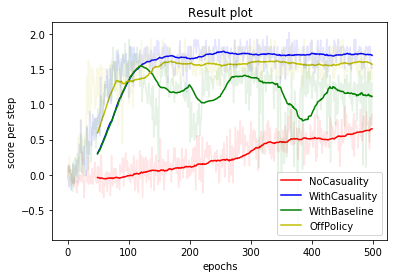

In [21]:
print("Stochastic transitions")
sf.plot_results([statsPGNC,statsPGwC,statsPGBS,statsPGOP],['NoCasuality','WithCasuality','WithBaseline','OffPolicy'], average_over=50)